![ibm-cloud.png](attachment:ibm-cloud.png)

The hype surrounding the combination of good data with state-of-the art machine learning can fall short of expectations.  There are many reasons for this, far too numerous to discuss in a single course, but there are some commonalities and trends.  See the white paper [Beyond the hype: A guide to understanding and successfully implementing artificial intelligence within your business](https://www.ibm.com/downloads/cas/8ZDXNKQ4) for a deeper dive into this topic.  This case study will focus on something that we are referring to as the *follow-through*.  

The basic idea of the follow-through is to tune, train and deploy your model, then once you have collected some performance data return to the familiar world of data visualization and hypothesis testing to investigate the relationship between model performance (evaluation metrics) and business metrics.

One of the reasons there has not been much focus on follow-through is that there are many projects and time is always precious.  The model is in production---okay what is the next project?  For this reason we propose readying your code for that post-performance investigation *before* the model is deployed. 

In [1]:
import os
import sys
import time
import re
import itertools
from string import punctuation, printable
import numpy as np
import pandas as pd
import spacy
import joblib
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction import text
import seaborn as sns

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## Suppress all warnings (not to be used during development)
#import warnings
#warnings.filterwarnings("ignore")

DATA_DIR = os.path.join(".", "sample_data")

Loading English Module...


## Synopsis


AAVAIL has recently enabled comments on its streaming service.  There are a number of data science projects that have become a priority since. Among other projects, the text will soon need to be monitored for automatic removal of inappropriate content.  Users and posts will need to be flagged for human review.  Your objective in this project will be to leverage comments for customer retention.  Following best practices, you are being asked now to build your code base to ensure you are ready when the first week of comments are ready.  Management has made the specific ask that they want you to monitor the relationship between your model's performance and a customer retention business metric.  

As a first pass we are going to perform text classification for customer retention. The movie comments data set with sentiment as a target is a perfect data set to start building a code base.  We are going to give several hints about how you could improve model performance as there are many options when it come to representing your text.  Once your have iterated with respect to transforms and models you will pass the model pipeline to a special function that will simulate model performance **and**  business performance for nine months.  Finally you will create a visualization to help investigate and monitor the relationship between the two.

## Outline


1. Optimize a text classification pipeline to be deployed for use
2. Iterate on and tune the model pipeline
3. Use visualization techniques to relate the evaluation metrics to the business metrics


## Data

In order to perform these tasks we have built a dataset combining two datasets: The AAVAIL stream dataset that summarizes the stream history of 1000 customers from 2018-2019, and the movie review dataset from [nltk_data](http://www.nltk.org/nltk_data) that contains movie reviews with their corresponding sentiment labels (1 if the review is positive and 0 if the review is negative). This combined dataset has 17695 rows (one row per stream session) and 8 columns:
* <u>customer_id</u> : The id of the customer that generated this stream.
* <u>stream_id</u> : The id of the stream.
* <u>date</u>  : The date of the stream.
* <u>invoice_item_id</u> : An indication of the type of subscription of the customer.
* <u>subscription_stopped</u> : Boolean variable equal to 1 if the customer stopped it's subscription after this stream and 0 otherwise.
* <u>comments</u> : A comment that the customer left after this stream. NaN if the customer didn't write a comment.
* <u>sentiments</u>  : The actual sentiment of the comment. NaN if the customer didn't write a comment.
* <u>M-Y</u> : The month and year of the stream (this column is redundant with the date column but can be used to aggregate the data by month).

We built this data by imputing reviews and their sentiment labels from the movie reviews dataset to the AAVAIL streams dataset. The format of these data is very close to the real dataset that the AAVAIL API will return once the comment feature is deployed.

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "simulated_user_comments.csv"))

# we create two lists, X and y that contains the user comments and the corresponding sentiments, respectively.
X = df[~df['comments'].isna()]['comments'].tolist()
y = df[~df['sentiments'].isna()]['sentiments'].tolist()
target_names = ['neg', 'pos']

In [3]:
df.head(2)

,customer_id,stream_id,date,invoice_item_id,subscription_stopped,comments,sentiments,M-Y
0,1,1420.0,2018-10-21,2.0,0,NaN,NaN,2018-10
1,1,1343.0,2018-10-23,2.0,0,NaN,NaN,2018-10


In [4]:
df.describe(include=np.object).transpose()

,count,unique,top,freq
date,17695,609,2019-09-03,88
comments,1132,1132,apollo 13 is simply one of the most dramatic f...,1
M-Y,17695,21,2019-08,1946


In [5]:
df.isna().sum()

customer_id                 0
stream_id                   0
date                        0
invoice_item_id             0
subscription_stopped        0
comments                16563
sentiments              16563
M-Y                         0
dtype: int64

In [6]:
df['sentiments'].unique()

array([nan,  1.,  0.])

In [7]:
print("length of the array is : {}:{}" .format(len(X), len(y)))

length of the array is : 1132:1132


In [8]:
X[0]

'few films in 1999 have divided the critical consensus as sharply as alan parker\'s adaptation of frank mccourt\'s memoir angela\'s ashes . \nmany dismissed it as an humorless , sentimentalized , uninteresting version of the hugely popular novel ; others hailed it as a heartfelt , sincere portrait of the human spirit . \ni\'m somewhere in between , leaning strongly towards the latter . \nit\'s certainly well-made and it never becomes tedious like some literary adaptations have a tendency to be . \nbut i have a feeling that parker filled the movie with pseudo-lyrical shots of rain falling on the homely streets of ireland just so it can have the two-and-a-half hour running time that screams " i\'m important ! " \nmccourt\'s book of the same name was about him and his family moving from the us to ireland in the early 1900\'s , a time when most people were desperately trying to get into the us . \nas he comments , " we were the only irishfolk to say goodbye to the statue of liberty . " \ni

### QUESTION 1

Before jumping to the preprocessing and the modeling phase, let's perform some EDA on the text data. Create a corpus_summary function that print statements and visualization to summarize the data. Two useful metrics are the number of different words in the full corpus and the number of words per comments but feel free to create your own metrics to summarize this data.

---------------------------
num docs 1132
median tokens 711.0
num tokens 863620
unique tokens 42523
---------------------------


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


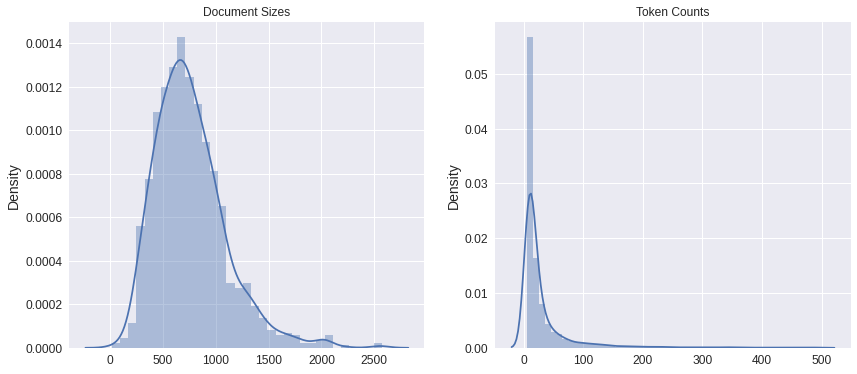

In [10]:
## YOUR CODE HERE
def plot_corpus_summary(corpus):
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    

    #-------------------------------------------------------------------

    tokens_per_doc = [len(str(doc).split(" ")) for doc in corpus]
    all_docs = [str(doc).split(" ") for doc in corpus]
    all_docs = list(itertools.chain.from_iterable(all_docs))
    unique_tokens, token_counts = np.unique(all_docs, return_counts=True)
    
    #---------------------------------------------------------------------

    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens",np.median(tokens_per_doc))
    print("num tokens",len(all_docs))
    print("unique tokens", unique_tokens.size)
    print("---------------------------")
  




    sns.distplot(tokens_per_doc, ax=ax1)
    sns.distplot([x for x in token_counts if (x>5)&(x<500)], ax=ax2)
    ax1.set_title("Document Sizes")
    ax2.set_title("Token Counts") 
    
plot_corpus_summary(X)

### QUESTION 2

Process the data.  There are many options to consider when you process the tokens from a 
corpus of text.  These are some of the questions you might want to ask?

* Which stop words do I include?
* Which stemmer/lemmatizer is best?
* Which n-grams do I include?
* Do I filter based on frequency min an max?

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spaCy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. 

Make sure spaCy is installed and that you downloaded an English language model for the package.

```bash
~$ pip install spacy
~$ python -m spacy download en
```

Use the following function to process your data into into a clean corpus. Note that this may take a few minutes. 

In [13]:
import spacy
STOPLIST = text.ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])


    


In [14]:
def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## Ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # Remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)   

In [16]:
## Example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n\n"+processed[0])

pron fool people time people time pron fool people time abraham lincoln


pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [17]:
## YOUR CODE HERE
from tqdm import tqdm
tqdm.pandas()

saved_data_filename =  os.path.join(DATA_DIR, "simulated_user_comments_processed.csv")
if not os.path.exists(saved_data_filename):
    df['processed_comments'] = df.progress_apply(lambda x : lemmatize_document(x['comments'], stop_words=STOPLIST), axis=1)
    df.to_csv(saved_data_filename, index=False)
else:
    print("loading {} from file".format(saved_data_filename))
    df = pd.read_csv(saved_data_filename)

processed_corpus = df[~df['comments'].isna()]['processed_comments'].tolist()

loading ./sample_data/simulated_user_comments_processed.csv from file


In [20]:
processed_corpus[0]

'film 1999 divide critical consensus sharply alan parkers adaptation frank mccourts memoir angelas ashe dismiss pron humorless sentimentalize uninteresting version hugely popular novel hail pron heartfelt portrait human spirit pron lean strongly pron certainly wellmade pron tedious like literary adaptation tendency feeling parker movie pseudolyrical shot rain fall homely street ireland just pron twoandahalf hour running time scream pron important mccourts book pron pron family ireland early 1900s time people desperately try pron comment pron irishfolk say goodbye statue liberty ireland frank play joe breen small child pron brother pron mother angela emily watson pron father malachy robert carlyle financial help angelas mother stereotypically strict catholic chide pron daughter marry northern irishman pron help pron ratinfeste apartment malachy look job position scarce pron finally pron unable hold pron pron fondness drink frank uptight catholic school instructor beat student blunt wood

### QUESTION 3

Using the function that you created in Question 1, summarize the processed data.

---------------------------
num docs 1132
median tokens 325.0
num tokens 393177
unique tokens 29980
---------------------------


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


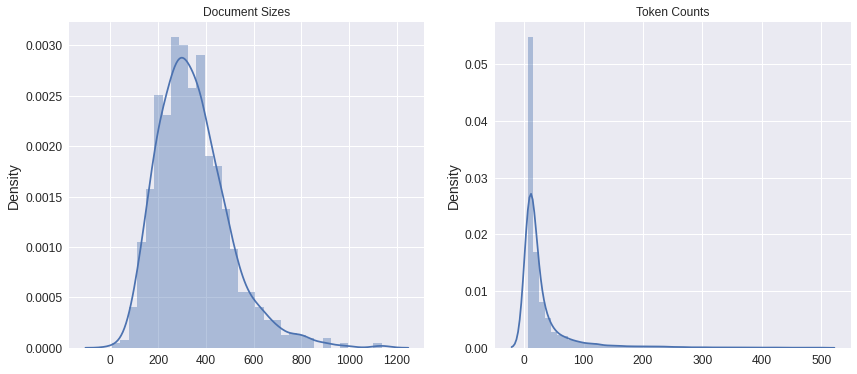

In [21]:
plot_corpus_summary(processed_corpus)

### QUESTION 4

A [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) is a representation of text.  A document or sentence is represented as numeric counts of the individual words, without considering grammar and punctuation.  Even the word order is ignored unless you expand your feature matrix with [n-grams](https://en.wikipedia.org/wiki/N-gram).

The most common type matrix derived from the bag-of-words representation **term frequency (TF)**, which is the number of times a token appears in the text.  Another useful matrix is the [term frequency-inverse document frequency (tf-idf)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) matrix. There are variations on tf-idf and in general these derived matrices can be thought of as *transforms* that can be optimized in an iterative fashion.
   
Finish the pipeline with a naive Bayes classifier to compare transforms

Naive Bayes approaches are a commonly used base model for text
classification.

There are several types of Naive Bayes model.

* Gaussian: It is used in classification and it assumes that features follow a normal distribution.
* Multinomial: It is used for discrete counts.
* Bernoulli: The binomial model is useful if your feature vectors are binary (i.e. zeros and ones).
* Complement: CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets

In the next coding cell, we split the dataset into a test set and a training set. Then, you will have to create a text classification pipeline to predict the sentiment of the comments. The first part of the pipeline should transform the processed text to a vector representation, the second part is the classifier estimator. In this question we ask you to use one of the Naive Bayes model presented above.

In [22]:
# Some additional EDA allowed us to observe that the first month and last month of the data are incomplete.
# Because we want to link the model's impact on the churn rate at a monthly level, 
# we remove the last month and the first month of the analysis.

# Moreover, in order to better test the future impact of our model we take as test set the last 3 complete 
# months of the dataset and use the rest of the data for the training set.

df_test = df[df['M-Y'].astype(str).isin(['2019-08', '2019-07', '2019-06'])].copy(deep=True)
df_train = df[~df['M-Y'].astype(str).isin(['2019-08', '2019-07', '2019-06', '2019-09', '2018-01'])].copy(deep=True)

# we extract from these two datasets the comments and the sentiment labels which are our independent 
# and dependent variables, repectively.
def create_sentiment_data(df):
    X = df.dropna()['processed_comments']
    y = df.dropna()['sentiments']
    return X, y

X_train, y_train = create_sentiment_data(df_train)
X_test, y_test = create_sentiment_data(df_test)

print("---------------------------")
print("train", sorted(Counter(y_train).items()))
print("test", sorted(Counter(y_test).items()))
print("targets", target_names)
print("---------------------------")

---------------------------
train [(0.0, 178), (1.0, 579)]
test [(0.0, 110), (1.0, 238)]
targets ['neg', 'pos']
---------------------------


In [23]:
X_train.head(10)


6     film 1999 divide critical consensus sharply al...
7     capsule liebe meet tod film sex death morgue a...
9     mickey mouse watch pron new critter town pron ...
10    like american history theater video feature fi...
13    old saying state leave good george lucas certa...
16    martin scorseses kundun chronicle roughly year...
17    ingredient pour rain small flood town damn bur...
51    pron inner flag halfmast year nick nite pull d...
53    thing bad watch bad movie realize film lot pot...
54    90 unwelcome thriller trend return grave pron ...
Name: processed_comments, dtype: object

In [24]:
y_train.head(10)

6     1.0
7     0.0
9     1.0
10    1.0
13    1.0
16    1.0
17    1.0
51    0.0
53    0.0
54    0.0
Name: sentiments, dtype: float64

In [26]:
## YOUR CODE HERE (base model)
from sklearn.naive_bayes import MultinomialNB

time_start = time.time()
pipe1  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                         ('nb', MultinomialNB())])

param_grid1 = {
    'tfidf__max_df':[0.4, 0.6, 0.8],
    'tfidf__max_features': [2000, 4000, 6000],
    'nb__alpha':[0.01, 0.1, 1.0, 2.0]   
}





grid1 = GridSearchCV(pipe1, param_grid=param_grid1, cv=5, n_jobs=-1)
grid1.fit(X_train, y_train)
y_pred = grid1.predict(X_test)
print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(grid1.best_params_)

train time 00:00:42
              precision    recall  f1-score   support

         neg       0.87      0.18      0.30       110
         pos       0.72      0.99      0.83       238

    accuracy                           0.73       348
   macro avg       0.80      0.58      0.57       348
weighted avg       0.77      0.73      0.67       348

{'nb__alpha': 0.01, 'tfidf__max_df': 0.8, 'tfidf__max_features': 6000}


### QUESTION 5

See if you can beat the base model. Try other classifiers and other vectorization methods to beat the pipeline that we trained in the previous question
(HINT: try using the SGDClassifier)

In [27]:
# YOUR CODE HERE
from sklearn.linear_model import SGDClassifier

time_start = time.time()
pipe2  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                         ('sgd', SGDClassifier(penalty = 'elasticnet'))])

param_grid2 = {
    'tfidf__max_df':[0.4, 0.6, 0.8],
    'tfidf__max_features': [1000, 2000, 4000],
    'sgd__alpha':[0.0001, 0.001, 0.01],
    'sgd__l1_ratio':[ 0.20, 0.40, 0.50, 0.7]
}

grid2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5, n_jobs=-1)
grid2.fit(X_train, y_train)
y_pred = grid2.predict(X_test)
y_pred_train = grid2.predict(X_train)
print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(grid2.best_params_)

train time 00:02:12
              precision    recall  f1-score   support

         neg       0.86      0.51      0.64       110
         pos       0.81      0.96      0.88       238

    accuracy                           0.82       348
   macro avg       0.84      0.74      0.76       348
weighted avg       0.83      0.82      0.80       348

{'sgd__alpha': 0.0001, 'sgd__l1_ratio': 0.7, 'tfidf__max_df': 0.8, 'tfidf__max_features': 4000}


In [28]:
print(classification_report(y_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       178
         pos       1.00      1.00      1.00       579

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



### QUESTION 6

Now that you have a created a decent classifier, we want to investigate the relation between our predicted sentiment score and the churn rate.

First you should create a dataframe that summarizes the rate of churn per month, the average real sentiment, and the predicted sentiment per month. Then, as you would as part of EDA, you will investigate the relationship between the sentiment and the business metric. At a minimum, the investigation should involve visualization, but hypothesis testing and/or statistical models could also be useful here.

In [29]:
# First we add the prediction to the train and test datasets.
df_test['sentiment_pred']=np.nan
idxs = df_test[~df_test['comments'].isna()]['sentiment_pred'].index.tolist()
for i, idx in enumerate(idxs):
    df_test.loc[idx, 'sentiment_pred'] = y_pred[i]
    
df_train['sentiment_pred']=np.nan
idxs = df_train[~df_train['comments'].isna()]['sentiment_pred'].index.tolist()
for i, idx in enumerate(idxs):
    df_train.loc[idx, 'sentiment_pred'] = y_pred_train[i]
    
    
def create_visu(x):
    """
    This function computes the aggregated metrics
    Input : A group dataframe of the df_train or df_test dataframe grouped by M-Y
    Output : A pandas series with the following 3 aggregated metrics for this month :
            - The total number of actual positive comments
            - The total number of predicted positive comments
            - The total number of churn
    """    
    sentiment = x[~x['comments'].isna()]['sentiments'].sum()
    sentiment_pred = x[~x['comments'].isna()]['sentiment_pred'].sum()
    churn = x['subscription_stopped'].sum()
    return pd.Series({'sentiment': sentiment, 'sentiment_pred': sentiment_pred, 'churn': churn})

df_summary = pd.concat([df_train.groupby('M-Y').apply(create_visu), df_test.groupby('M-Y').apply(create_visu)])
df_summary.head()

,sentiment,sentiment_pred,churn
M-Y,,,
2018-02,11.0,11.0,0.0
2018-03,19.0,19.0,0.0
2018-04,25.0,25.0,4.0
2018-05,39.0,39.0,3.0
2018-06,39.0,39.0,10.0


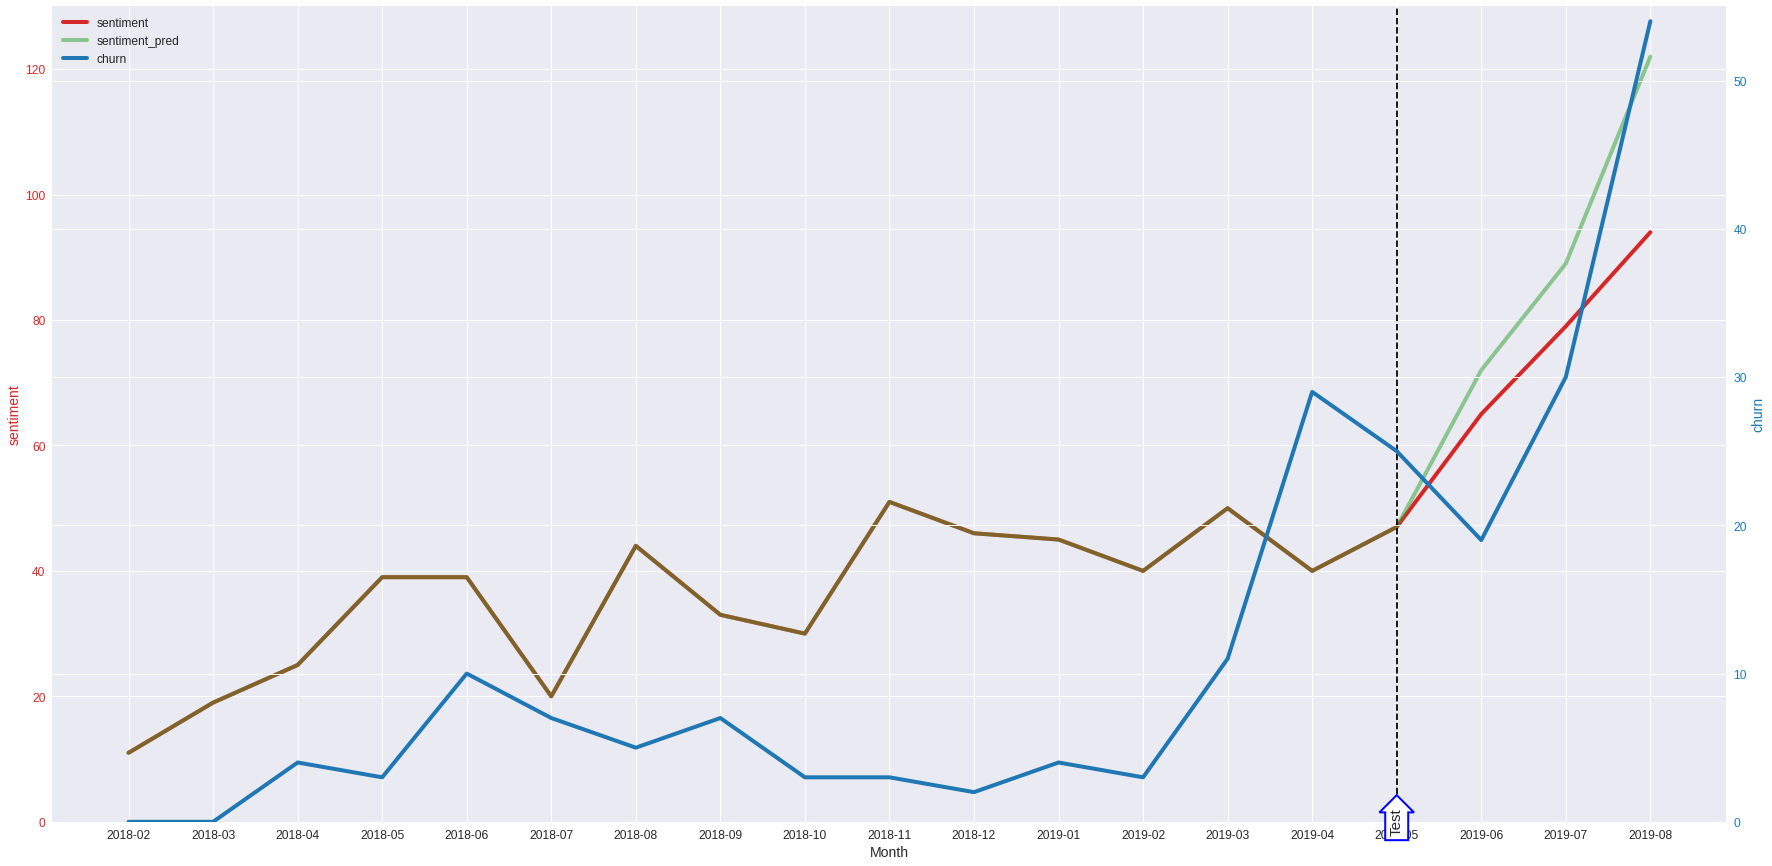

In [32]:
# YOUR CODE HERE

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(111)

n_months = df_summary.shape[0]

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('sentiment', color=color)
p1 = ax1.plot(df_summary.index.astype(str), df_summary['sentiment'], color=color, lw=4)
p2 = ax1.plot(df_summary.index.astype(str), df_summary['sentiment_pred'], color='tab:green', lw=4, alpha =0.5)
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim((0, 130))

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('churn', color=color)
p3 = ax2.plot(df_summary.index.astype(str), df_summary['churn'], color=color, lw=4)
ax2.tick_params(axis='y',labelcolor=color)
ax2.set_ylim((0, 55))

ax2.legend([p1[0], p2[0], p3[0]], ["sentiment", "sentiment_pred", "churn"])


bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(15, 0, "Test", ha="center", va="center", 
                 size=15,rotation=90,
                 bbox=bbox_props)
ax2.vlines(15, 0, 55, linestyles='--')

## Solution comments

We can see that the the churn rate seems to be negatively correlated with the churn rate. Building on this plot, we can fit a linear regression model to quantify the strength of the relation between these two variables.

In [33]:
df_summary.describe()

,sentiment,sentiment_pred,churn
count,19.000000,19.000000,19.000000
mean,43.000000,45.368421,11.526316
std,20.132892,25.826796,14.013360
min,11.000000,11.000000,0.000000
25%,31.500000,31.500000,3.000000
50%,40.000000,40.000000,5.000000
75%,48.500000,48.500000,15.000000
max,94.000000,122.000000,54.000000


In [38]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='churn ~ sentiment', data=df_summary)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     27.14
Date:                Fri, 01 Jan 2021   Prob (F-statistic):           7.09e-05
Time:                        02:32:59   Log-Likelihood:                -67.543
No. Observations:                  19   AIC:                             139.1
Df Residuals:                      17   BIC:                             141.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.9422      4.951     -2.412      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


### QUESTION 7 (Optional)

Finally, we want to simulate the business impact that our model would have once implemented to support a marketing strategy. This simulation will allow us to link the performance of our model to the retention metric.

##### Marketing strategy :
We describe the following simple marketing strategy : Every month, our model predicts the average sentiment score of every subscriber. Then, if the ratio of negative comments over positive comments is greater than a certain threshold for a specific customer, the marketing team will send an incentive to this customer. 
* <u>Assumption 1</u> : Based on previous marketing campaigns, we assume that the probability that a customer stays after receiving the incentive given that he wanted to un-subscribe in the near future follows a normal distribution with mean 0.6 and standard deviation 0.05.
* <u>Assumption 2</u> : The accuracy of our model in the coming months will follow a normal distribution with mean 0.81 and standard deviation 0.02.(based on cross validation across months on the training set).
* <u>Assumption 3</u> : The predictive model is only a function of it's accuracy. In other words, we will suppose that the proportions of false positives and false negatives are the equal. (This is a strong assumption but we will see later that it is possible to relax it).

The business metric that we will use to evaluate this simulated marketing campaign against the performance of our predictive model is the percent decrease in rate of churn when the strategy is implemented.

##### Simulated data:
To test this marketing strategy we simulated a dataset based on historical data. These data are very similar to the streams dataset: One row corresponds with one stream. The data has 4 columns:
* month
* customer_id 
* subscription_stopped -> whereas the customer stopped his subscription after this stream
* sentiment -> boolean variable that gives the sentiment (positive of negative) of a comment that the customer left after this stream.

In order to simplify this notebook we already generated this simulated dataset and saved it in the data folder. We will focus here on the implementation of the proposed marketing strategy and visualizing its business impact. Specifically, you'll investigate the relationship between the performance of our model and the retention metric. At a minimum the investigation should involve visualization, but hypothesis testing and/or statistical models could be useful here.

In [43]:
df_simulation = pd.read_csv(os.path.join(DATA_DIR, "simulation_data.csv"))

In [48]:
df_simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10847 entries, 0 to 10846
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     10847 non-null  int64  
 1   subscription_stopped            10847 non-null  int64  
 2   sentiments                      738 non-null    float64
 3   month                           10847 non-null  object 
 4   simulated_sentiments            738 non-null    float64
 5   simulated_subscription_stopped  10847 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 508.6+ KB


In [50]:
df_simulation.isna().sum(axis = 0)

customer_id                           0
subscription_stopped                  0
sentiments                        10109
month                                 0
simulated_sentiments              10109
simulated_subscription_stopped        0
dtype: int64

In [51]:
model_accuracy = 0.81


# We simulate the accuracy of our model on the comming months
simulated_acc = {month:np.random.normal(loc=model_accuracy, scale=0.02) for month in df_simulation['month'].unique()}


def simulate_model(x):
    """
    This function simulates the output of the model based on the simulated accuracy.
    Input : A group dataframe of df_simulation grouped by month.
    Output : A copy of the input dataframe with an additional column that gives the simulated sentiments.
    """
    df_tmp = x.copy()
    month = df_tmp['month'].iloc[0]
    acc = simulated_acc[month]
    df_tmp['simulated_sentiments'] = np.nan
    for i in range (len(df_tmp)):
        if df_tmp['sentiments'].iloc[i]==1 :
            if np.random.random() > acc :
                df_tmp['simulated_sentiments'].iloc[i]=0
            else :
                df_tmp['simulated_sentiments'].iloc[i]=1
        elif df_tmp['sentiments'].iloc[i]==0 :
            if np.random.random() > acc :
                df_tmp['simulated_sentiments'].iloc[i]=1
            else :
                df_tmp['simulated_sentiments'].iloc[i]=0
        else :
            pass
    return df_tmp
df_simulation = df_simulation.groupby('month').apply(simulate_model).reset_index(drop=True)


def apply_marketing_policy(x, threshold):
    """ 
    This function implements the marketing policy and outputs the customers that are selected for an incentive.
    Input : A group dataframe of df_simulation for a specific customer_id / the threshold that dicts whereas this
    customer should receive an incentive according to the simulated strategy.
    Output : 1 if this customer should receive an incentive and 0 otherwise.
    """
    if x['subscription_stopped'].max()>0 :
        nb_pos = float(x.dropna()['simulated_sentiments'].sum())
        len_ = float(len(x.dropna()))
        nb_neg = len_ - nb_pos
        ratio = nb_neg/(nb_pos+1)
        if ratio > threshold:
            return 1
        else :
            return 0
    else :
        return 0
flaged_customer = df_simulation.groupby('customer_id').apply(lambda x : apply_marketing_policy(x, 0.5))==1


def simulate_marketing_output(x):
    """
    This function simulates the output of the marketing strategy on the flagged customers.
    Input : A row of the df_simulation dataframe.
    Output : the simulated value of subscription stopped for this row.
    """
    if x['subscription_stopped'] == 1: # for efficiency
        if flaged_customer[x['customer_id']] : # if the customer has been flagged by the model
            if np.random.random() < np.random.normal(0.6, 0.05): # simulates the success of the incentive
                return 0
    return x['subscription_stopped']

df_simulation['simulated_subscription_stopped'] = df_simulation.apply(simulate_marketing_output, axis=1)



In [45]:
# YOUR CODE HERE (Replace the #<> symbols by your code)

def make_visualization_data(x):
    """
    This function creates the aggregated metrics that we want to vizualize.
    Input : One group dataframe of the df_simluation dataframe grouped by month (to see how one of these groups 
    look like you can use the pandas function get_group() on a DataFrameGroupBy pandas object)
    Output : A pandas series with the following aggregated metrics : 
            - The total number of actuall churn for this month
            - The total number of simulated churn for this month 
            - The total number of actuall positive comments
            - The total number of predicted positive comments
            - The model's accuracy for this month
    """
    month = x['month'].iloc[0]
    accuracy = simulated_acc[month]
    churn = x['subscription_stopped'].sum()
    simulated_churn = x['simulated_subscription_stopped'].sum()
    sentiment = x['sentiments'].sum()
    predicted_sentiment =  x['simulated_sentiments'].sum()
    return pd.Series({'churn': churn, 'simulated_churn': simulated_churn, 'sentiment':sentiment, 'predicted_sentiment':predicted_sentiment, 'accuracy':accuracy})



df_summary = df_simulation.groupby('month').apply(make_visualization_data)
# The buisness output of the marketing is measured with the percentage deacrease in number of churn per month.
df_summary['business_perf'] = 100*(df_summary['churn'] - df_summary['simulated_churn'])/df_summary['churn']

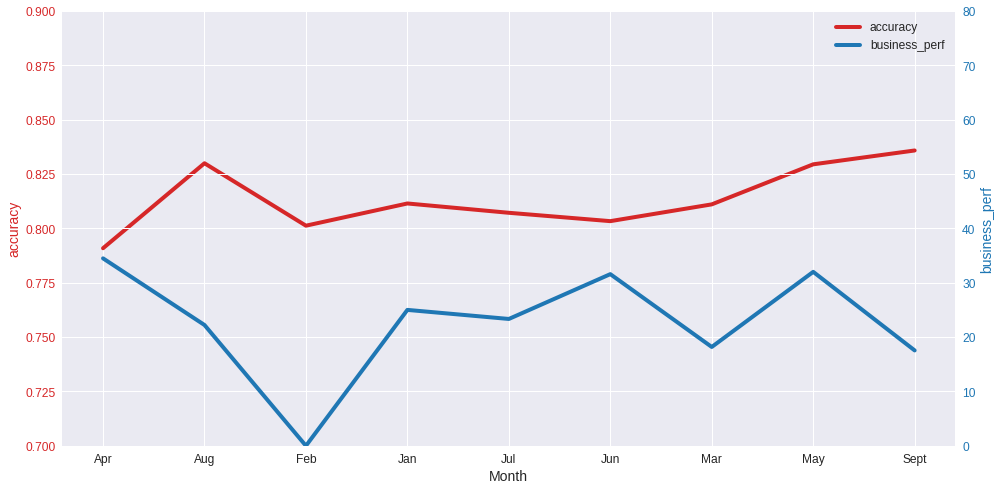

In [46]:
# YOUR CODE HERE

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

n_months = df_summary.shape[0]

ax1.set_xlabel('Month')
ax1.set_ylabel('accuracy', color='tab:red')
p1 = ax1.plot(df_summary.index.astype(str), df_summary['accuracy'], color='tab:red', lw=4)
ax1.tick_params(axis='y',labelcolor='tab:red')
ax1.set_ylim((0.7, 0.9))

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('business_perf', color='tab:blue')
p2 = ax2.plot(df_summary.index.astype(str), df_summary['business_perf'], color='tab:blue', lw=4)
ax2.tick_params(axis='y',labelcolor='tab:blue')
ax2.set_ylim((0, 80))

ax2.legend([p1[0], p2[0]], ["accuracy", "business_perf"])

## Solution comments

The above visualization shows a positive correlation between the performance of the classification model and the business performance metric. Further statistical analysis should be conducted to quantify the strength and amplitude of this correlation. As described in the previous question, fitting a linear model or conducting statistical tests would allow us to better describe the output of this simulation.

Moreover, some of the assumptions we took to build the simulation could be relaxed. For instance we simulated the prediction of the model only using the accuracy without maintaining the recall and precision of our model to their estimated level. Improving the simulation of the model will make the simulation more realistic and strengthen the interpretation of the simulation.